In [1]:
# import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
# parameter databases
params=pd.read_excel("C:\\Users\\Akash\\Desktop\\SAE\\params.xlsx", engine='openpyxl')
materials=pd.read_csv("C:\\Users\\Akash\\Desktop\\SAE\\materials.csv")
tires=pd.read_csv("C:\\Users\\Akash\\Desktop\\SAE\\tires.csv")
motors=pd.read_csv("C:\\Users\\Akash\\Desktop\\SAE\\motors.csv")
brakes=pd.read_csv("C:\\Users\\Akash\\Desktop\\SAE\\brakes.csv")
suspension=pd.read_csv("C:\\Users\\Akash\\Desktop\\SAE\\suspension.csv")

In [4]:
# constants
v_car = 26.8 # m/s
w_e = 3600*2*np.pi/60 # radians/sec
rho_air = 1.225 # kg/m3
r_track = 9 # m
P_brk = 10**7 # Pascals
C_dc = 0.04 # drag coefficient of cabin
gravity = 9.81 # m/s^2
y_suspension = 0.05 # m
dydt_suspension = 0.025 # m/s
# weights for composing objective from subobjectives
weightsNull = np.ones(11) / 11
weights1 = np.array([14,1,20,30,10,1,1,10,10,2,1])/100
weights2 = np.array([25,1,15,20,15,1,1,15,5,1,1])/100
weights3 = np.array([14,1,20,15,25,1,1,10,10,2,1])/100

In [21]:
class car:
    def __init__(self): # initialize a random car
        # continuous parameters with fixed bounds
        for i in range(19):
            setattr(self, params.at[i, 'variable'], random.uniform(params.at[i, 'min'], params.at[i, 'max']))
        
        # mateials
        for i in range(5):
            setattr(self, params.at[19+i, 'variable'], materials.at[random.randint(0,12),'q'])       
        setattr(self, 'Eia', self.qia*1000000)  
        
        # rear tires
        temp = random.randint(0,6)
        setattr(self, params.at[25, 'variable'], tires.at[temp,'radius'])
        setattr(self, params.at[26, 'variable'], tires.at[temp,'mass'])
        # fron tires
        temp = random.randint(0,6)
        setattr(self, params.at[27, 'variable'], tires.at[temp,'radius'])
        setattr(self, params.at[28, 'variable'], tires.at[temp,'mass'])
        
        # engine
        temp = random.randint(0,20)
        setattr(self, params.at[29, 'variable'], motors.at[temp,'Power'])
        setattr(self, params.at[30, 'variable'], motors.at[temp,'Length'])
        setattr(self, params.at[31, 'variable'], motors.at[temp,'Height'])
        setattr(self, params.at[32, 'variable'], motors.at[temp,'Torque'])
        setattr(self, params.at[33, 'variable'], motors.at[temp,'Mass'])
        
        # brakes
        temp = random.randint(0,33)
        setattr(self, params.at[34, 'variable'], brakes.at[temp,'rbrk'])
        setattr(self, params.at[35, 'variable'], brakes.at[temp,'qbrk'])
        setattr(self, params.at[36, 'variable'], brakes.at[temp,'lbrk'])
        setattr(self, params.at[37, 'variable'], brakes.at[temp,'hbrk'])
        setattr(self, params.at[38, 'variable'], brakes.at[temp,'wbrk'])
        setattr(self, params.at[39, 'variable'], brakes.at[temp,'tbrk'])
        
        # suspension
        temp = random.randint(0,4)
        setattr(self, params.at[40, 'variable'], suspension.at[temp,'krsp'])
        setattr(self, params.at[41, 'variable'], suspension.at[temp,'crsp'])
        setattr(self, params.at[42, 'variable'], suspension.at[temp,'mrsp'])
        setattr(self, params.at[43, 'variable'], suspension.at[temp,'kfsp'])
        setattr(self, params.at[44, 'variable'], suspension.at[temp,'cfsp'])
        setattr(self, params.at[45, 'variable'], suspension.at[temp,'mfsp'])
        
        # continuous parameters with variable bounds
        setattr(self, 'wrw', random.uniform(0.3, r_track - 2 * self.rrt))
        setattr(self, 'yrw', random.uniform(.5 + self.hrw / 2, 1.2 - self.hrw / 2))
        setattr(self, 'yfw', random.uniform(0.03 + self.hfw / 2, .25 - self.hfw/2))
        setattr(self, 'ysw', random.uniform(0.03 + self.hsw/2, .250 - self.hsw/2))
        setattr(self, 'ye', random.uniform(0.03 + self.he / 2, .5 - self.he / 2))
        setattr(self, 'yc', random.uniform(0.03 + self.hc / 2, 1.200 - self.hc / 2))
        setattr(self, 'lia', random.uniform(0.2, .7  - self.lfw))
        setattr(self, 'yia', random.uniform(0.03 + self.hia / 2, 1.200 - self.hia / 2))
        setattr(self, 'yrsp', random.uniform(self.rrt, self.rrt * 2))
        setattr(self, 'yfsp', random.uniform(self.rft, self.rft * 2))
    
    # mass of subsystems
    def mrw(self):
        return self.lrw * self.wrw *self.hrw * self.qrw
    def mfw(self):
        return self.lfw * self.wfw *self.hfw * self.qfw
    def msw(self):
        return self.lsw * self.wsw *self.hsw * self.qsw
    def mia(self):
        return self.lia * self.wia *self.hia * self.qia
    def mc(self):
        return 2*(self.hc*self.lc*self.tc + self.hc*self.wc*self.tc + self.lc*self.hc*self.tc)*self.qc
    def mbrk(self):
        return self.lbrk * self.wbrk * self.hbrk * self.qbrk
    
    # objective 1 - mass (minimize)
    def mass(self):
        mass = self.mrw() + self.mfw() + 2 * self.msw() + 2*self.mrt + 2*self.mft + self.me + self.mc() + self.mia() + 4*self.mbrk() + 2*self.mrsp + 2*self.mfsp
        return mass
    
    # objective 2 - centre of gravity height (minimize)
    def cGy(self):
        t1 = (self.mrw()*self.yrw + self.mfw()*self.yfw+ self.me*self.ye + self.mc()*self.yc + self.mia()*self.yia) / self.mass()
        t2 = 2*(self.msw()*self.ysw + self.mrt*self.rrt + self.mft*self.rft + self.mbrk()*self.rft + self.mrsp*self.yrsp + self.mfsp*self.yfsp) / self.mass()
        return t1 + t2
    
    # aspect ratio of wing
    def AR(self,w,alpha,l):
        return w* np.cos(alpha) / l

    # lift co-effecient
    def C_lift(self,AR,alpha):
        return 2*np.pi* (AR / (AR + 2)) * alpha
    
    # drag co-efficient
    def C_drag(self,C_lift, AR):
        return C_lift**2 / (np.pi * AR)
    
    # wing downforce
    def F_down_wing(self,w,h,l,alpha,rho_air,v_car):
        wingAR = self.AR(w,alpha,l)
        C_l = self.C_lift(wingAR, alpha)
        return 0.5 * alpha * h * w * rho_air * (v_car**2) * C_l
    
    # wing drag
    def F_drag_wing(self,w,h,l,alpha,rho_air,v_car):
        wingAR = self.AR(w,alpha,l)
        C_l = self.C_lift(wingAR, alpha)
        C_d = self.C_drag(C_l,wingAR)
        return self.F_drag(w,h,rho_air,v_car,C_d)
    
    # drag
    def F_drag(self,w,h,rho_air,v_car,C_d):
        return 0.5*w*h*rho_air*v_car**2*C_d

    # objective 3 - total drag (minimize)
    def F_drag_total(self):
        cabinDrag = self.F_drag(self.wc,self.hc,rho_air,v_car,C_dc)
        rearWingDrag = self.F_drag_wing(self.wrw,self.hrw,self.lrw,self.arw,rho_air,v_car)
        frontWingDrag = self.F_drag_wing(self.wfw,self.hfw,self.lfw,self.afw,rho_air,v_car)
        sideWingDrag = self.F_drag_wing(self.wsw,self.hsw,self.lsw,self.asw,rho_air,v_car)
        return rearWingDrag + frontWingDrag + 2* sideWingDrag + cabinDrag
    
    # objective 4 - total downforce (maximize)
    def F_down_total(self):
        downForceRearWing = self.F_down_wing(self.wrw,self.hrw,self.lrw,self.arw,rho_air,v_car)
        downForceFrontWing = self.F_down_wing(self.wfw,self.hfw,self.lfw,self.afw,rho_air,v_car)
        downForceSideWing = self.F_down_wing(self.wsw,self.hsw,self.lsw,self.asw,rho_air,v_car)
        return downForceRearWing + downForceFrontWing + 2*downForceSideWing
    
    # rolling resistance co-efficient
    def rollingResistance(self,tirePressure,v_car):
        C = .005 + 1/tirePressure * (.01 + .0095 * ((v_car*3.6/100)**2))
        return C * self.mass() * gravity
    
    # objective 5 - acceleration (maximize)
    def acceleration(self):
        mTotal = self.mass()
        tirePressure = self.Prt
        total_resistance = self.F_drag_total() + self.rollingResistance(tirePressure,v_car)

        w_wheels = v_car / self.rrt
        efficiency = total_resistance * v_car / self.Phi_e
        torque = self.T_e
    
        F_wheels = torque * efficiency * w_e /(self.rrt * w_wheels)

        return (F_wheels - total_resistance) / mTotal
    
    # objective 6 - crash force (minimize)
    def crashForce(self):
        return np.sqrt(self.mass() * v_car**2 * self.wia * self.hia * self.Eia / (2*self.lia))
    
    # objective 7 - impact attenuator volume (minimize)
    def iaVolume(self):
        return self.lia*self.wia*self.hia
    
    def suspensionForce(self,k,c):
        return k*y_suspension + c*dydt_suspension

    # objective 8 - corner velocity in skid pad (maximize)
    def cornerVelocity(self):
        F_fsp = self.suspensionForce(self.kfsp,self.cfsp)
        F_rsp = self.suspensionForce(self.krsp,self.crsp)
        downforce = self.F_down_total()
        mTotal = self.mass()

        C = self.rollingResistance(self.Prt,v_car)
        forces = downforce+mTotal*gravity-2*F_fsp-2*F_rsp
        if forces < 0:
            return 0
        return np.sqrt(forces * C * r_track / mTotal)
    
    # objective 9 - (minimize)
    def breakingDistance(self):
        mTotal = self.mass()
        C = self.rollingResistance(self.Prt,v_car)

        A_brk = self.hbrk * self.wbrk
        c_brk = .37
        Tbrk = 2 * c_brk * P_brk * A_brk * self.rbrk

        # y forces:
        F_fsp = self.suspensionForce(self.kfsp,self.cfsp)
        F_rsp = self.suspensionForce(self.krsp,self.crsp)
        Fy = mTotal*gravity + self.F_down_total() - 2 * F_rsp - 2*F_fsp
        if Fy<=0: Fy = 1E-10
        a_brk = Fy * C / mTotal + 4*Tbrk*C/(self.rrt*mTotal)
        return (v_car**2 / (2*a_brk))
    
    # objective 10 - (minimize) 
    def suspensionAcceleration(self):
        Ffsp = self.suspensionForce(self.kfsp,self.cfsp)
        Frsp = self.suspensionForce(self.krsp,self.crsp)
        mTotal = self.mass()
        Fd = self.F_down_total()
        return (2*Ffsp - 2*Frsp - mTotal*gravity - Fd)/mTotal
    
    # objective 11 - (minimize)
    def pitchMoment(self):
        Ffsp = self.suspensionForce(self.kfsp,self.cfsp)
        Frsp = self.suspensionForce(self.krsp,self.crsp)
        downForceRearWing = self.F_down_wing(self.wrw,self.hrw,self.lrw,self.arw,rho_air,v_car)
        downForceFrontWing = self.F_down_wing(self.wfw,self.hfw,self.lfw,self.afw,rho_air,v_car)
        downForceSideWing = self.F_down_wing(self.wsw,self.hsw,self.lsw,self.asw,rho_air,v_car)
        lcg = self.lc
        lf = 0.5
        return 2*Ffsp*lf + 2*Frsp*lf + downForceRearWing*(lcg - self.lrw) - downForceFrontWing*(lcg-self.lfw) - 2*downForceSideWing*(lcg-self.lsw)
    
    # global objective
    def objective(self, weights):
        return(self.mass()*weights[0]+self.cGy()*weights[1]+self.F_drag_total()*weights[2]-self.F_down_total()*weights[3]-self.acceleration()*weights[4]+self.crashForce()*weights[5]+self.iaVolume()*weights[6]-self.cornerVelocity()*weights[7]+self.breakingDistance()*weights[8]+self.suspensionAcceleration()*weights[9]+self.pitchMoment()*weights[10])
    
    # calculate penalty for violating constraints
    def constraints(self):
        pen = 0
        if (self.wrw < 0.3):
            pen = pen + (self.wrw-0.3)**2
        if (self.wrw > r_track - 2 * self.rrt):
            pen = pen + (self.wrw > r_track - 2 * self.rrt)**2
        
        if(self.yrw < .5 + self.hrw / 2):
            pen = pen + (self.yrw - .5 + self.hrw / 2)**2
        if(self.yrw > 1.2 - self.hrw / 2):
            pen = pen + (self.yrw - 1.2 - self.hrw / 2)**2
        
        if(self.yfw < 0.03 + self.hfw / 2):
            pen = pen + (self.yfw - 0.03 + self.hfw / 2)**2
        if(self.yfw > .25 - self.hfw/2):
            pen = pen + (self.yfw - .25 - self.hfw/2)**2
       
        if(self.ysw < 0.03 + self.hsw/2):
            pen = pen + (self.ysw - 0.03 + self.hsw/2)**2
        if(self.ysw > .250 - self.hsw/2):
            pen = pen + (self.ysw - .250 - self.hsw/2)**2
        
        if(self.ye < 0.03 + self.he / 2):
            pen = pen + (self.ye - 0.03 + self.he / 2)**2
        if(self.ye > .5 - self.he / 2):
            pen = pen + (self.ye - .5 - self.he / 2)**2
       
        if(self.yc < 0.03 + self.hc / 2):
            pen = pen + (self.yc - 0.03 + self.hc / 2)**2
        if(self.yc > 1.200 - self.hc / 2):
            pen = pen + (self.yc - 1.200 - self.hc / 2)**2
       
        if(self.lia < 0.2):
            pen = pen + (self.lia - 0.2)**2
        if(self.lia > .7  - self.lfw):
            pen = pen + (self.lia - .7  - self.lfw)**2
        
        if(self.yia < 0.03 + self.hia / 2):
            pen = pen + (self.yia - 0.03 + self.hia / 2)**2
        if(self.yia > 1.200 - self.hia / 2):
            pen = pen + (self.yia - 1.200 - self.hia / 2)**2
        
        if(self.yrsp < self.rrt):
            pen = pen + (self.yrsp - self.rrt)**2
        if(self.yrsp > self.rrt * 2):
            pen = pen + (self.yrsp - self.rrt * 2)**2
  
        if(self.yfsp < self.rft):
            pen = pen + (self.yfsp - self.rft)**2
        if(self.yfsp > self.rft * 2):
            pen = pen + (self.yfsp - self.rft * 2)**2
        
        if (self.F_down_total()+self.mass()*gravity-2*self.suspensionForce(self.kfsp,self.cfsp)-2*self.suspensionForce(self.krsp,self.crsp) < 0):
            pen = pen + (self.F_down_total()+self.mass()*gravity-2*self.suspensionForce(self.kfsp,self.cfsp)-2*self.suspensionForce(self.krsp,self.crsp))**2
        
        if (self.mass()*gravity + self.F_down_total() - 2*self.suspensionForce(self.krsp,self.crsp) - 2*self.suspensionForce(self.kfsp,self.cfsp) < 0):
            pen = pen + (self.mass()*gravity + self.F_down_total() - 2*self.suspensionForce(self.krsp,self.crsp) - 2*self.suspensionForce(self.kfsp,self.cfsp))**2
        
        return(pen)    

In [66]:
all_objective = []
all_mass = []
all_cGy = []
all_F_drag_total = []
all_F_down_total = []
all_acceleration = []
all_crashForce = []
all_iaVolume = []
all_cornerVelocity = []
all_breakingDistance = []
all_suspensionAcceleration = []
all_pitchMoment = []

In [67]:
for i in range(100000):
    mycar=car()
    if (mycar.constraints() == 0):
        all_objective.append(mycar.objective(weights1))
        all_mass.append(mycar.mass())
        all_cGy.append(mycar.cGy())
        all_F_drag_total.append(mycar.F_drag_total())
        all_F_down_total.append(mycar.F_down_total())
        all_acceleration.append(mycar.acceleration())
        all_crashForce.append(mycar.crashForce())
        all_iaVolume.append(mycar.iaVolume())
        all_cornerVelocity.append(mycar.cornerVelocity())
        all_breakingDistance.append(mycar.breakingDistance())
        all_suspensionAcceleration.append(mycar.suspensionAcceleration())
        all_pitchMoment.append(mycar.pitchMoment())

In [68]:
print(all_objective[np.argmin(all_objective)])
print(all_mass[np.argmin(all_objective)])
print(all_cGy[np.argmin(all_objective)])
print(all_F_drag_total[np.argmin(all_objective)])
print(all_F_down_total[np.argmin(all_objective)])
print(all_acceleration[np.argmin(all_objective)])
print(all_crashForce[np.argmin(all_objective)])
print(all_iaVolume[np.argmin(all_objective)])
print(all_cornerVelocity[np.argmin(all_objective)])
print(all_breakingDistance[np.argmin(all_objective)])
print(all_suspensionAcceleration[np.argmin(all_objective)])
print(all_pitchMoment[np.argmin(all_objective)])

22066.834998063536
108.49119489821969
0.4917370930467272
52.06261828691629
69.12556944397436
0.1856251330274016
2206176.026787363
0.02236387908602347
26.28026370147921
0.3568208837879832
-10.447153729469235
302.58189399074


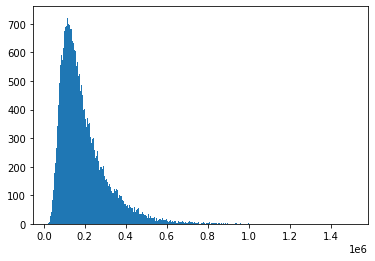

In [69]:
myhist=plt.hist(all_objective, bins=1000)

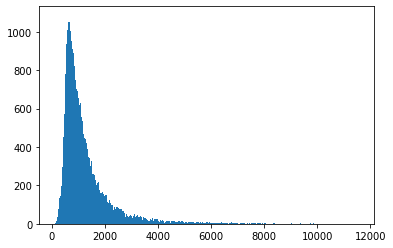

In [70]:
myhist=plt.hist(all_mass, bins=1000)

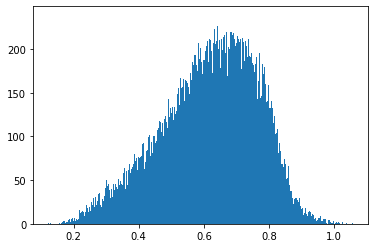

In [71]:
myhist=plt.hist(all_cGy, bins=1000)

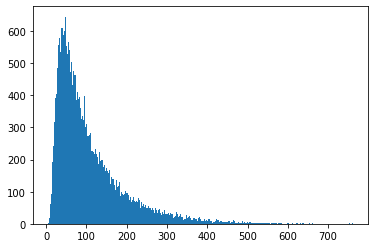

In [72]:
myhist=plt.hist(all_F_drag_total, bins=1000)

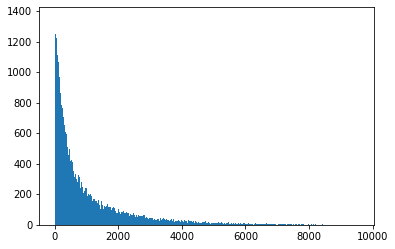

In [73]:
myhist=plt.hist(all_F_down_total, bins=1000)

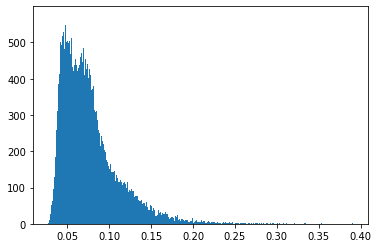

In [74]:
myhist=plt.hist(all_acceleration, bins=1000)

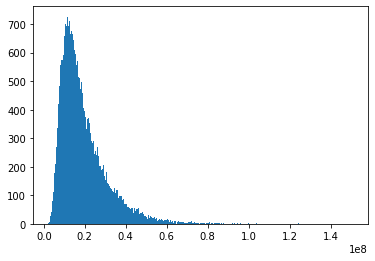

In [75]:
myhist=plt.hist(all_crashForce, bins=1000)

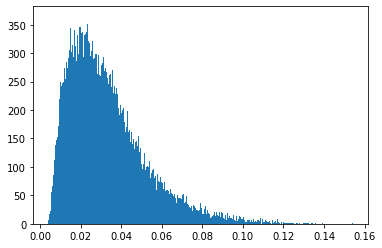

In [76]:
myhist=plt.hist(all_iaVolume, bins=1000)

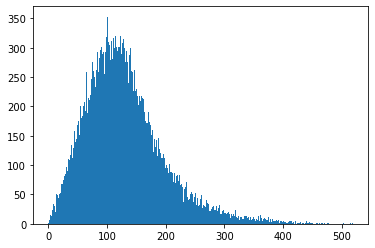

In [77]:
myhist=plt.hist(all_cornerVelocity, bins=1000)

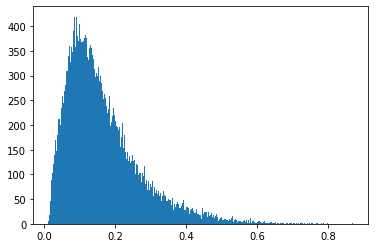

In [78]:
myhist=plt.hist(all_breakingDistance, bins=1000)

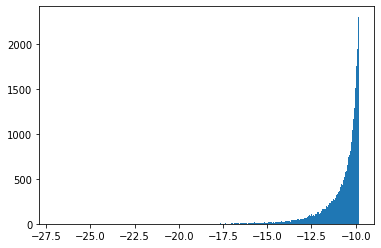

In [79]:
myhist=plt.hist(all_suspensionAcceleration, bins=1000)

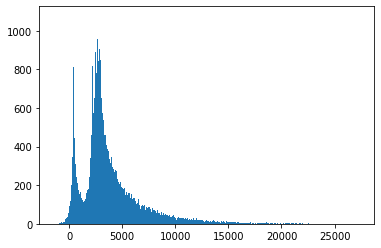

In [80]:
myhist=plt.hist(all_pitchMoment, bins=1000)

In [99]:
# evaluations at midrange
for i in range(19):
    setattr(mycar, params.at[i, 'variable'], params.at[i, 'value'])

for i in range(5):
    setattr(mycar, params.at[19+i, 'variable'], materials.at[6,'q'])
    params.at[19+i, 'value'] = materials.at[6,'q']

setattr(mycar, 'Eia', mycar.qia*1000000)  
params.at[24, 'value'] = mycar.qia*1000000

setattr(mycar, params.at[25, 'variable'], tires.at[3,'radius'])
setattr(mycar, params.at[26, 'variable'], tires.at[3,'mass'])

setattr(mycar, params.at[27, 'variable'], tires.at[3,'radius'])
setattr(mycar, params.at[28, 'variable'], tires.at[3,'mass'])

setattr(mycar, params.at[29, 'variable'], motors.at[10,'Power'])
setattr(mycar, params.at[30, 'variable'], motors.at[10,'Length'])
setattr(mycar, params.at[31, 'variable'], motors.at[10,'Height'])
setattr(mycar, params.at[32, 'variable'], motors.at[10,'Torque'])
setattr(mycar, params.at[33, 'variable'], motors.at[10,'Mass'])

setattr(mycar, params.at[34, 'variable'], brakes.at[17,'rbrk'])
setattr(mycar, params.at[35, 'variable'], brakes.at[17,'qbrk'])
setattr(mycar, params.at[36, 'variable'], brakes.at[17,'lbrk'])
setattr(mycar, params.at[37, 'variable'], brakes.at[17,'hbrk'])
setattr(mycar, params.at[38, 'variable'], brakes.at[17,'wbrk'])
setattr(mycar, params.at[39, 'variable'], brakes.at[17,'tbrk'])

setattr(mycar, params.at[40, 'variable'], suspension.at[2,'krsp'])
setattr(mycar, params.at[41, 'variable'], suspension.at[2,'crsp'])
setattr(mycar, params.at[42, 'variable'], suspension.at[2,'mrsp'])
setattr(mycar, params.at[43, 'variable'], suspension.at[2,'kfsp'])
setattr(mycar, params.at[44, 'variable'], suspension.at[2,'cfsp'])
setattr(mycar, params.at[45, 'variable'], suspension.at[2,'mfsp'])

for i in range(10):
    setattr(mycar, params.at[i+46, 'variable'], params.at[i+46, 'value'])

In [100]:
# objectives at midrange
obj=np.full(12, 0.0)
obj[0]=mycar.objective(weights1)
obj[1]=mycar.mass()
obj[2] = mycar.cGy()
obj[3] = mycar.F_drag_total()
obj[4] = mycar.F_down_total()
obj[5] = mycar.acceleration()
obj[6] = mycar.crashForce()
obj[7] = mycar.iaVolume()
obj[8] = mycar.cornerVelocity()
obj[9] = mycar.breakingDistance()
obj[10] = mycar.suspensionAcceleration()
obj[11] = mycar.pitchMoment()

In [101]:
# objectives at midrange + delta
arr = np.full((56,12), 0.0)
for i in range(56):
    midrange_val = getattr(mycar, params.at[i, 'variable'])
    setattr(mycar, params.at[i, 'variable'], midrange_val + 0.00001)
    
    arr[(i,0)] = mycar.objective(weights1)
    arr[(i,1)] = mycar.mass()
    arr[(i,2)] = mycar.cGy()
    arr[(i,3)] = mycar.F_drag_total()
    arr[(i,4)] = mycar.F_down_total()
    arr[(i,5)] = mycar.acceleration()
    arr[(i,6)] = mycar.crashForce()
    arr[(i,7)] = mycar.iaVolume()
    arr[(i,8)] = mycar.cornerVelocity()
    arr[(i,9)] = mycar.breakingDistance()
    arr[(i,10)] = mycar.suspensionAcceleration()
    arr[(i,11)] = mycar.pitchMoment()
    
    setattr(mycar, params.at[i, 'variable'], midrange_val)

In [102]:
# store slopes in arr
for i in range(56):
    for j in range(12):
        arr[(i,j)] = (arr[(i,j)] - obj[j])/0.00001

In [103]:
# evaluate constants
const = np.full(12, 0.0)
for j in range(12):
    sum = 0
    for i in range(56):
        sum = sum + getattr(mycar, params.at[i, 'variable'])*arr[i,j]
    const[j] = obj[j] - sum

In [104]:
# kth objective - simplified
def objectives_simplified(test_car, k):
    sum = 0
    for i in range(56):
        sum = sum + getattr(test_car, params.at[i, 'variable'])*arr[i,k]
    return(sum+const[k])

In [110]:
all_objective_s = []
all_mass_s = []
all_cGy_s = []
all_F_drag_total_s = []
all_F_down_total_s = []
all_acceleration_s = []
all_crashForce_s = []
all_iaVolume_s = []
all_cornerVelocity_s = []
all_breakingDistance_s = []
all_suspensionAcceleration_s = []
all_pitchMoment_s = []

all_objective_o = []
all_mass_o = []
all_cGy_o = []
all_F_drag_total_o = []
all_F_down_total_o = []
all_acceleration_o = []
all_crashForce_o = []
all_iaVolume_o = []
all_cornerVelocity_o = []
all_breakingDistance_o = []
all_suspensionAcceleration_o = []
all_pitchMoment_o = []

In [111]:
for i in range(100000):
    mycar=car()

    if (mycar.constraints() == 0):
        all_objective_s.append(objectives_simplified(mycar, 0))
        all_mass_s.append(objectives_simplified(mycar, 1))
        all_cGy_s.append(objectives_simplified(mycar, 2))
        all_F_drag_total_s.append(objectives_simplified(mycar, 3))
        all_F_down_total_s.append(objectives_simplified(mycar, 4))
        all_acceleration_s.append(objectives_simplified(mycar, 5))
        all_crashForce_s.append(objectives_simplified(mycar, 6))
        all_iaVolume_s.append(objectives_simplified(mycar, 7))
        all_cornerVelocity_s.append(objectives_simplified(mycar, 8))
        all_breakingDistance_s.append(objectives_simplified(mycar, 9))
        all_suspensionAcceleration_s.append(objectives_simplified(mycar, 10))
        all_pitchMoment_s.append(objectives_simplified(mycar, 11))
            
        all_objective_o.append(mycar.objective(weights1))
        all_mass_o.append(mycar.mass())
        all_cGy_o.append(mycar.cGy())
        all_F_drag_total_o.append(mycar.F_drag_total())
        all_F_down_total_o.append(mycar.F_down_total())
        all_acceleration_o.append(mycar.acceleration())
        all_crashForce_o.append(mycar.crashForce())
        all_iaVolume_o.append(mycar.iaVolume())
        all_cornerVelocity_o.append(mycar.cornerVelocity())
        all_breakingDistance_o.append(mycar.breakingDistance())
        all_suspensionAcceleration_o.append(mycar.suspensionAcceleration())
        all_pitchMoment_o.append(mycar.pitchMoment())

In [113]:
err=np.array(all_crashForce_s)-np.array(all_crashForce_o)

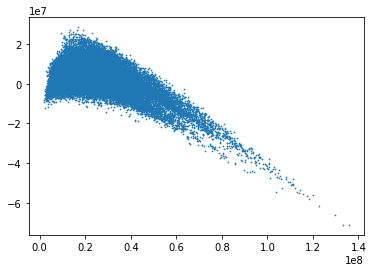

In [116]:
plt.scatter(all_crashForce_o, err, s=0.5)